# Battery Optimisation

<br>

Why synthetic data? In part because it allows the mode to be extended in a large number of ways, for example if you want to train an NN to operate a virtual battery in this system you could give it an 'unlimited' amount of data which could greatly improve training.

### Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import battery as bt
import hierro

import pickle

<br>

### Single Simulation

In [25]:
def run_simulation(df_hierro, battery, time_step=1/6):
    df_hierro['battery_state'] = pd.Series()
    df_hierro['new_delta'] = pd.Series()

    for i in range(df_hierro.shape[0]):
        delta = df_hierro.iloc[i]['delta']
        battery_state = battery.state

        ## Charging
        if (battery_state < battery.capacity) & (delta < 0):
            power_limit = min(battery.power, (battery.capacity-battery_state)/time_step, np.abs(delta))
            battery.charge(power_limit, time_step)

            df_hierro.at[i, 'battery_state'] = battery.state
            df_hierro.at[i, 'new_delta'] = delta + power_limit

        ## Disharging
        elif (battery_state > 0) & (delta > 0):
            power_limit = min(battery.power, battery_state/time_step, np.abs(delta))
            battery.discharge(power_limit, time_step)

            df_hierro.at[i, 'battery_state'] = battery.state
            df_hierro.at[i, 'new_delta'] = delta - power_limit

        else:
            df_hierro.at[i, 'battery_state'] = battery.state
            df_hierro.at[i, 'new_delta'] = delta

    return df_hierro, battery

## Defining Model
power = 20 # MW
capacity = 270 # MWh
turbines = 5
panels = 0

## Initialising
battery = bt.Battery(power, capacity, efficiency=0.9)
df_hierro = hierro.create_hierro(turbines, panels)

## Running Simulation
df_hierro, battery = run_simulation(df_hierro, battery)

## Printing results
print(f'Battery Capacity: {capacity} MWh')
gen_shortcoming, gen_excess = hierro.calc_imbalance(df_hierro, delta_col='new_delta')
print(f'Demand met by renewables: {round(100*(1-gen_shortcoming/df_hierro.demand.sum()), 2)}%')
print('')
        
df_hierro.head()

Battery Capacity: 270 MWh
Generation shortcoming: 11.5 GWh
Generation excess: 0.6 GWh

Demand met by renewables: 74.3%



,datetime,demand,solar_0.0MW,wind_11.5MW,delta,battery_state,new_delta
0,2021-01-01 00:00:00,4.4,0.0,0.000025,4.399975,0.0,4.399975
1,2021-01-01 00:10:00,4.7,0.0,0.000000,4.700000,0.0,4.700000
2,2021-01-01 00:20:00,4.2,0.0,0.000000,4.200000,0.0,4.200000
3,2021-01-01 00:30:00,4.4,0.0,0.000000,4.400000,0.0,4.400000
4,2021-01-01 00:40:00,4.3,0.0,0.000410,4.299590,0.0,4.299590


<br>

### Construction of Model's Dictionary & Pretty Printer

In [3]:
def construct_model_dict(power, capacity, turbines, panels, df_hierro, gen_shortcoming, gen_excess):
    model = {
        'components' : {
            'battery' : {
                'power' : {
                    'value' : power,
                    'units' : '(MW)',
                },
                'capacity' : {
                    'value' : capacity,
                    'units' : '(MWh)',
                },
            },
            'wind' : {
                'turbines' : {
                    'value' : turbines,
                    'units' : '',
                },
                'capacity' : {
                    'value' : turbines*2.3,
                    'units' : '(MW)'
                },
            },
            'solar' : {
                'panels' : {
                    'value' : panels,
                    'units' : '',
                },
                'capacity' : {
                    'value' : panels*3/1000,
                    'units' : '(MW)'
                },
            },
        },
        'results' : {
            'total_demand' : {
                'value' : df_hierro.demand.sum()/6000,
                'units' : '(GWh)',
            },
            'excess' : {
                'value' : gen_excess/6000,
                'units' : '(GWh)',
            },
            'shortcoming' : {
                'value' : gen_shortcoming/6000,
                'units' : '(GWh)',
            },
            'demand_met_by_renewables' : {
                'value' : 100*(1-gen_shortcoming/df_hierro.demand.sum()),
                'units' : '(%)',
            },
        },
        'timeseries' : df_hierro, # Can add .to_json() but slows down printing
    }

    return model

def pretty_print_system(model_dict):
    print('System:')
    for component in model_dict['components']:
        print(f'\t{component.capitalize()}')
        for info in model_dict['components'][component]:
            print(f'\t{info.capitalize()}: {model_dict["components"][component][info]["value"]} {model_dict["components"][component][info]["units"]}')
        print()
    print('\nResults:')
    for result in model_dict['results']:
        print(f'\t{result.replace("_", " ").capitalize()}: {round(model_dict["results"][result]["value"], 1)} {model_dict["results"][result]["units"]}')
    print('\n\n')
    
model_dict = construct_model_dict(power, capacity, turbines, panels, df_hierro, gen_shortcoming, gen_excess)
pretty_print_system(model_dict)

System:
	Battery
	Power: 20 (MW)
	Capacity: 200 (MWh)

	Wind
	Turbines: 5 
	Capacity: 11.5 (MW)

	Solar
	Panels: 0 
	Capacity: 0.0 (MW)


Results:
	Total demand: 44.8 (GWh)
	Excess: 1.1 (GWh)
	Shortcoming: 12.0 (GWh)
	Demand met by renewables: 73.3 (%)





### Grid Search

In [7]:
%%time

#with open('data/models_dict.pickle', 'rb') as handle:
#    models_dict = pickle.load(handle)

## Defining model parameters
power_range = [20] # MW
capacities = [50, 270, 305]#[0, 1, 2, 3, 5, 10, 25, 50, 100, 200, 400, 800] # MWh
num_turbines = [5] #[1, 2, 3, 4, 5, 7, 10, 12, 15]
num_panels = [0] #[0, 1000, 2000, 4000, 6000, 8000]

## Iterating over parameter space
i = 0
for power in power_range:
    for capacity in capacities:
        for turbines in num_turbines:
            for panels in num_panels:
                i += 1

                ## Simulation
                run_model = True
                if run_model == True:
                    print(f'Running {i} of {len(power_range)*len(capacities)*len(num_turbines)*len(num_panels)}')
                    
                    ## Initialising
                    battery = bt.Battery(power, capacity, efficiency=0.7)
                    df_hierro = hierro.create_hierro(turbines, panels)

                    ## Running calculations
                    df_hierro, battery = run_simulation(df_hierro, battery)
                    gen_shortcoming, gen_excess = hierro.calc_imbalance(df_hierro, delta_col='new_delta', _print=False)

                ## Recording model 
                save_model = True
                if save_model == True:
                    model_name = f'P{power}_C{capacity}_T{turbines}_S{panels}'
                    model_dict = construct_model_dict(power, capacity, turbines, panels, df_hierro, gen_shortcoming, gen_excess)
                    models_dict[model_name] = model_dict
                    pretty_print_system(model_dict)
                    
    
save_models = False
if save_models == True:
    with open('data/models_dict.pickle', 'wb') as handle:
        pickle.dump(models_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running 1 of 3
System:
	Battery
	Power: 20 (MW)
	Capacity: 50 (MWh)

	Wind
	Turbines: 5 
	Capacity: 11.5 (MW)

	Solar
	Panels: 0 
	Capacity: 0.0 (MW)


Results:
	Total demand: 44.8 (GWh)
	Excess: 2.9 (GWh)
	Shortcoming: 14.6 (GWh)
	Demand met by renewables: 67.5 (%)



Running 2 of 3
System:
	Battery
	Power: 20 (MW)
	Capacity: 270 (MWh)

	Wind
	Turbines: 5 
	Capacity: 11.5 (MW)

	Solar
	Panels: 0 
	Capacity: 0.0 (MW)


Results:
	Total demand: 44.8 (GWh)
	Excess: 0.1 (GWh)
	Shortcoming: 12.6 (GWh)
	Demand met by renewables: 71.9 (%)



Running 3 of 3
System:
	Battery
	Power: 20 (MW)
	Capacity: 305 (MWh)

	Wind
	Turbines: 5 
	Capacity: 11.5 (MW)

	Solar
	Panels: 0 
	Capacity: 0.0 (MW)


Results:
	Total demand: 44.8 (GWh)
	Excess: 0.0 (GWh)
	Shortcoming: 12.5 (GWh)
	Demand met by renewables: 72.0 (%)



Wall time: 58.4 s


In [57]:
df_models = pd.DataFrame(columns=['battery_power', 'battery_capacity', 'wind_turbines', 'wind_capacity', 'solar_panels', 'solar_capacity', 'total_demand_capacity', 'excess_capacity', 'shortcoming_capacity', 'demand_met_by_renewables_capacity'])

for model in models_dict.keys():
    
    for component in models_dict[model]['components']:
        for key in models_dict[model]['components'][component].keys():
            value = models_dict[model]['components'][component][key]['value']
            df_models.loc[model, f'{component}_{key}'] = value
            
    for result in models_dict[model]['results']:i
        value = models_dict[model]['results'][result]['value']
        df_models.loc[model, f'{result}_{key}'] = value
  
if save_models == True:
    df_models.reset_index().rename(columns={'index':'model_name'}).to_csv('data/df_models.csv', index=False)
    
df_models.head()

,battery_power,battery_capacity,wind_turbines,wind_capacity,solar_panels,solar_capacity,total_demand_capacity,excess_capacity,shortcoming_capacity,demand_met_by_renewables_capacity
P20_C0_T0_S0,20,0,0,0,0,0,44.8235,0,44.8235,0
P20_C0_T0_S1000,20,0,0,0,1000,4,44.8235,0,39.4581,11.97
P20_C0_T0_S2000,20,0,0,0,2000,8,44.8235,0.0239482,34.1166,23.8867
P20_C0_T0_S4000,20,0,0,0,4000,16,44.8235,5.4692,28.8311,35.6785
P20_C0_T0_S6000,20,0,0,0,6000,24,44.8235,14.6107,27.2419,39.2241


<br>

### Cost Assignment

In [4]:
df_models = pd.read_csv('data/df_models.csv')
df_models = df_models.set_index('model_name').rename(columns={'demand_met_by_renewables_capacity':'renew_pct'})
df_models.head()

,battery_power,battery_capacity,wind_turbines,wind_capacity,solar_panels,solar_capacity,total_demand_capacity,excess_capacity,shortcoming_capacity,renew_pct
model_name,,,,,,,,,,
P20_C0_T0_S0,20,0,0,0.0,0,0.0,44.82345,0.000000,44.823450,0.000000
P20_C0_T0_S1000,20,0,0,0.0,1000,4.0,44.82345,0.000000,39.458064,11.970043
P20_C0_T0_S2000,20,0,0,0.0,2000,8.0,44.82345,0.023948,34.116626,23.886658
P20_C0_T0_S4000,20,0,0,0.0,4000,16.0,44.82345,5.469199,28.831104,35.678526
P20_C0_T0_S6000,20,0,0,0.0,6000,24.0,44.82345,14.610720,27.241853,39.224105


<br>

#### Wind Turbines:

https://www.renewablesfirst.co.uk/windpower/windpower-learning-centre/how-much-does-a-farm-wind-turbine-small-wind-farm-turbine-cost/ - £3.1M/turbine (Enercon E-82)

https://nwtresearch.com/sites/default/files/inuvikmarch2015.pdf - p19 - ~\$9.7M/turbine (Enercon E-70)

http://s3platform.jrc.ec.europa.eu/documents/20182/167224/3-1+iColak-WindEnrgy-in-Turkey-CBA_WindTurbines_June2016-3.pdf/63addbb2-528f-4a88-8ab0-3be4764f4824 - p53 - £2.6M/turbine (26 turbines Enercon E-82)

Will assume ~£3M/turbine for this work = \$1700/kW

http://newenergyupdate.com/wind-energy-update/us-wind-om-costs-estimated-48000mw-falling-costs-create-new-industrial-uses-iea - "O&M costs average between \$42,000 and \$48,000/MW during the first 10 years of a wind turbine’s operations" - \$4.5/kW.yr

<br>

#### Solar Panels:

https://emp.lbl.gov/sites/default/files/lbnl_utility_scale_solar_2018_edition_report.pdf - aggregate of 560 projects

Installed: \$2000/kW

O&M: \$8.4/MWh or \$15.8/kW.yr

<br>

#### Storage

https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2017/Oct/IRENA_Electricity_Storage_Costs_2017_Summary.pdf?la=en&hash=2FDC44939920F8D2BA29CB762C607BC9E882D4E9 - p13 - \$580/kWh Installation

https://www.ifc.org/wps/wcm/connect/ed6f9f7f-f197-4915-8ab6-56b92d50865d/7151-IFC-EnergyStorage-report.pdf?MOD=AJPERES - p12 - \$47.3/kW.yr

In [5]:
cost_dict = {
    'Installed Value' : {
        'Wind' : 1700,
        'Solar' : 2000,
        'Storage' : 580,
    },
    'Installed Units' : {
        'Wind' : '$/kW',
        'Solar' : '$/kW',
        'Storage' : '$/kWh',
    },
    'O&M Value' : {
        'Wind' : 4.5,
        'Solar' : 15.8,
        'Storage' : 47.3,
    },
    'O&M Units' : {
        'Wind' : '$/kW.yr',
        'Solar' : '$/kW.yr',
        'Storage' : '$/kW.yr',
    },
}

df_costs = pd.DataFrame(cost_dict)

df_costs_pp = (pd.DataFrame()
               .assign(Installed = df_costs['Installed Value'].astype(str) + ' (' + df_costs['Installed Units'] + ')')
               .assign(OM = df_costs['O&M Value'].astype(str) + ' (' + df_costs['O&M Units'] + ')')
               .rename(columns={'OM':'O&M'})
              )
print(df_costs_pp)

           Installed             O&M
Solar    2000 ($/kW)  15.8 ($/kW.yr)
Storage  580 ($/kWh)  47.3 ($/kW.yr)
Wind     1700 ($/kW)   4.5 ($/kW.yr)


In [6]:
## Here we'll compare our predicted costs with the existing Tesla battery in South West Australia
## Should note that Tesla battery was done over a very short time period and expected to be more expensive

tesla_Aus_cost = 90.6 * 1000000
tesla_Aus_capacity = 129 # MWh

pred_cost = tesla_Aus_capacity * 1000 * df_costs.loc['Storage', 'Installed Value']
error = 100*(pred_cost - tesla_Aus_cost)/tesla_Aus_cost

print(f'Error: {round(error, 1)}%')

## Should repeat for wind and solar

Error: -17.4%


In [7]:
## Should look at adding an island factor for costs e.g. x1.1 - Should be something in the IRENA document

(0, 729098477.8699899)

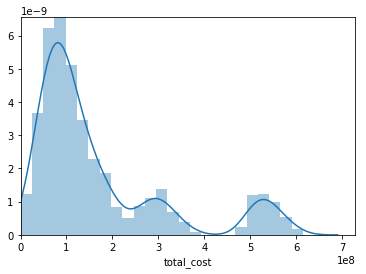

In [8]:
## Capital Costs
s_battery_cap_cost = df_models['battery_capacity'] * 1000 * df_costs.loc['Storage', 'Installed Value']
s_wind_cap_cost = df_models['wind_capacity'] * 1000 * df_costs.loc['Wind', 'Installed Value']
s_solar_cap_cost = df_models['solar_capacity'] * (3/4) * 1000 * df_costs.loc['Solar', 'Installed Value'] # 3/4 is for initial solar error

## Operating costs - Calculated over a 30yr lifetime
years = 30
s_battery_op_cost = df_models['battery_power'] * 1000 * years * df_costs.loc['Storage', 'O&M Value']
s_wind_op_cost = df_models['wind_capacity'] * 1000 * years * df_costs.loc['Wind', 'O&M Value']
s_solar_op_cost = df_models['solar_capacity'] * (3/4) * 1000 * years * df_costs.loc['Solar', 'O&M Value']

s_battery_op_cost.loc[s_battery_cap_cost==0] = 0

s_cap_cost = s_battery_cap_cost + s_wind_cap_cost + s_solar_cap_cost
s_op_cost = s_battery_op_cost + s_wind_op_cost + s_solar_op_cost
s_total_cost = s_cap_cost + s_op_cost

df_models['cap_cost'] = s_cap_cost
df_models['op_cost'] = s_op_cost
df_models['total_cost'] = s_total_cost

sns.distplot(df_models['total_cost'])
plt.xlim(0)

(0, 100)

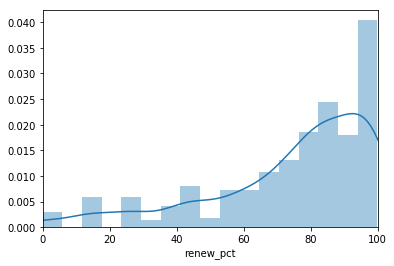

In [9]:
sns.distplot(df_models['renew_pct'])
plt.xlim(0, 100)

In [10]:
df_cheapest_models = pd.DataFrame()

for pct_renew in range(0, 101):
    try:
        cheapest_model = df_models[df_models['renew_pct']>=pct_renew].sort_values('total_cost').index[0]
        total_cost = df_models.loc[cheapest_model, 'total_cost']
        renew_pct = df_models.loc[cheapest_model, 'renew_pct']

        df_cheapest_models.loc[pct_renew, 'model'] = cheapest_model
        df_cheapest_models.loc[pct_renew, 'total_cost'] = total_cost
        df_cheapest_models.loc[pct_renew, 'renew_pct'] = renew_pct
    except:
        df_cheapest_models.loc[pct_renew] = np.nan
    
df_cheapest_models.loc[0, 'total_cost'] = 0
df_cheapest_models.head()

,model,total_cost,renew_pct
0,P20_C0_T0_S0,0.0,0.000000
1,P20_C0_T1_S0,4220500.0,15.457574
2,P20_C0_T1_S0,4220500.0,15.457574
3,P20_C0_T1_S0,4220500.0,15.457574
4,P20_C0_T1_S0,4220500.0,15.457574


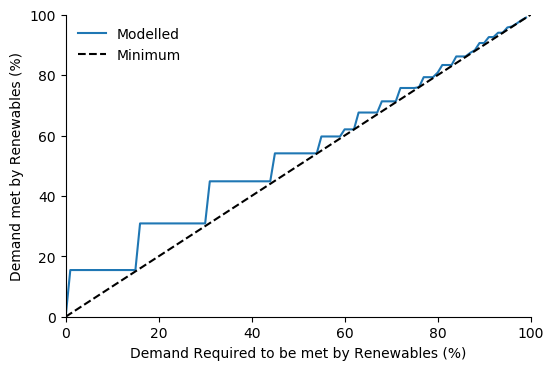

In [11]:
fig = plt.figure(dpi=100)
ax = plt.subplot()   

df_cheapest_models['renew_pct'].plot(ax=ax, label='Modelled')
ax.plot([0, 100], [0, 100], 'k--', label='Minimum')

plt.xlim(0, 100)
plt.ylim(0, 100)

plt.ylabel('Demand met by Renewables (%)')
plt.xlabel('Demand Required to be met by Renewables (%)')

plt.legend(frameon=False)

ax.spines['right'].set_visible(False)     
ax.spines['top'].set_visible(False)

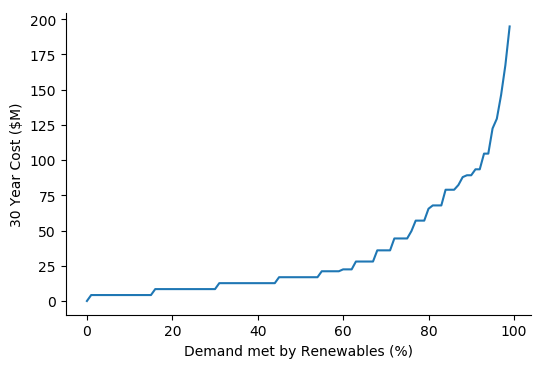

In [12]:
fig = plt.figure(dpi=100)
ax = plt.subplot()     
    
ax.plot(df_cheapest_models.index, df_cheapest_models['total_cost']/1000000)

plt.ylabel('30 Year Cost ($M)')
plt.xlabel('Demand met by Renewables (%)')

ax.spines['right'].set_visible(False)     
ax.spines['top'].set_visible(False)

In [13]:
## Should run more models at the lower end of the spectrum to smooth out the curve
## Should also looking at plotting costs as a stacked plot with separate parts for each fuel type

In [14]:
df_cheapest_models = df_cheapest_models.reset_index().rename(columns={'index':'req_renew_pct'}).set_index('model')

df_cheapest_models['battery_cost'] = s_battery_cap_cost + s_battery_op_cost
df_cheapest_models['wind_cost'] = s_wind_cap_cost + s_wind_op_cost
df_cheapest_models['solar_cost'] = s_solar_cap_cost + s_solar_op_cost

df_cheapest_models = df_cheapest_models.dropna()

df_cheapest_models.head()

,req_renew_pct,total_cost,renew_pct,battery_cost,wind_cost,solar_cost
model,,,,,,
P20_C0_T0_S0,0,0.0,0.000000,0.0,0.0,0.0
P20_C0_T1_S0,1,4220500.0,15.457574,0.0,4220500.0,0.0
P20_C0_T1_S0,2,4220500.0,15.457574,0.0,4220500.0,0.0
P20_C0_T1_S0,3,4220500.0,15.457574,0.0,4220500.0,0.0
P20_C0_T1_S0,4,4220500.0,15.457574,0.0,4220500.0,0.0


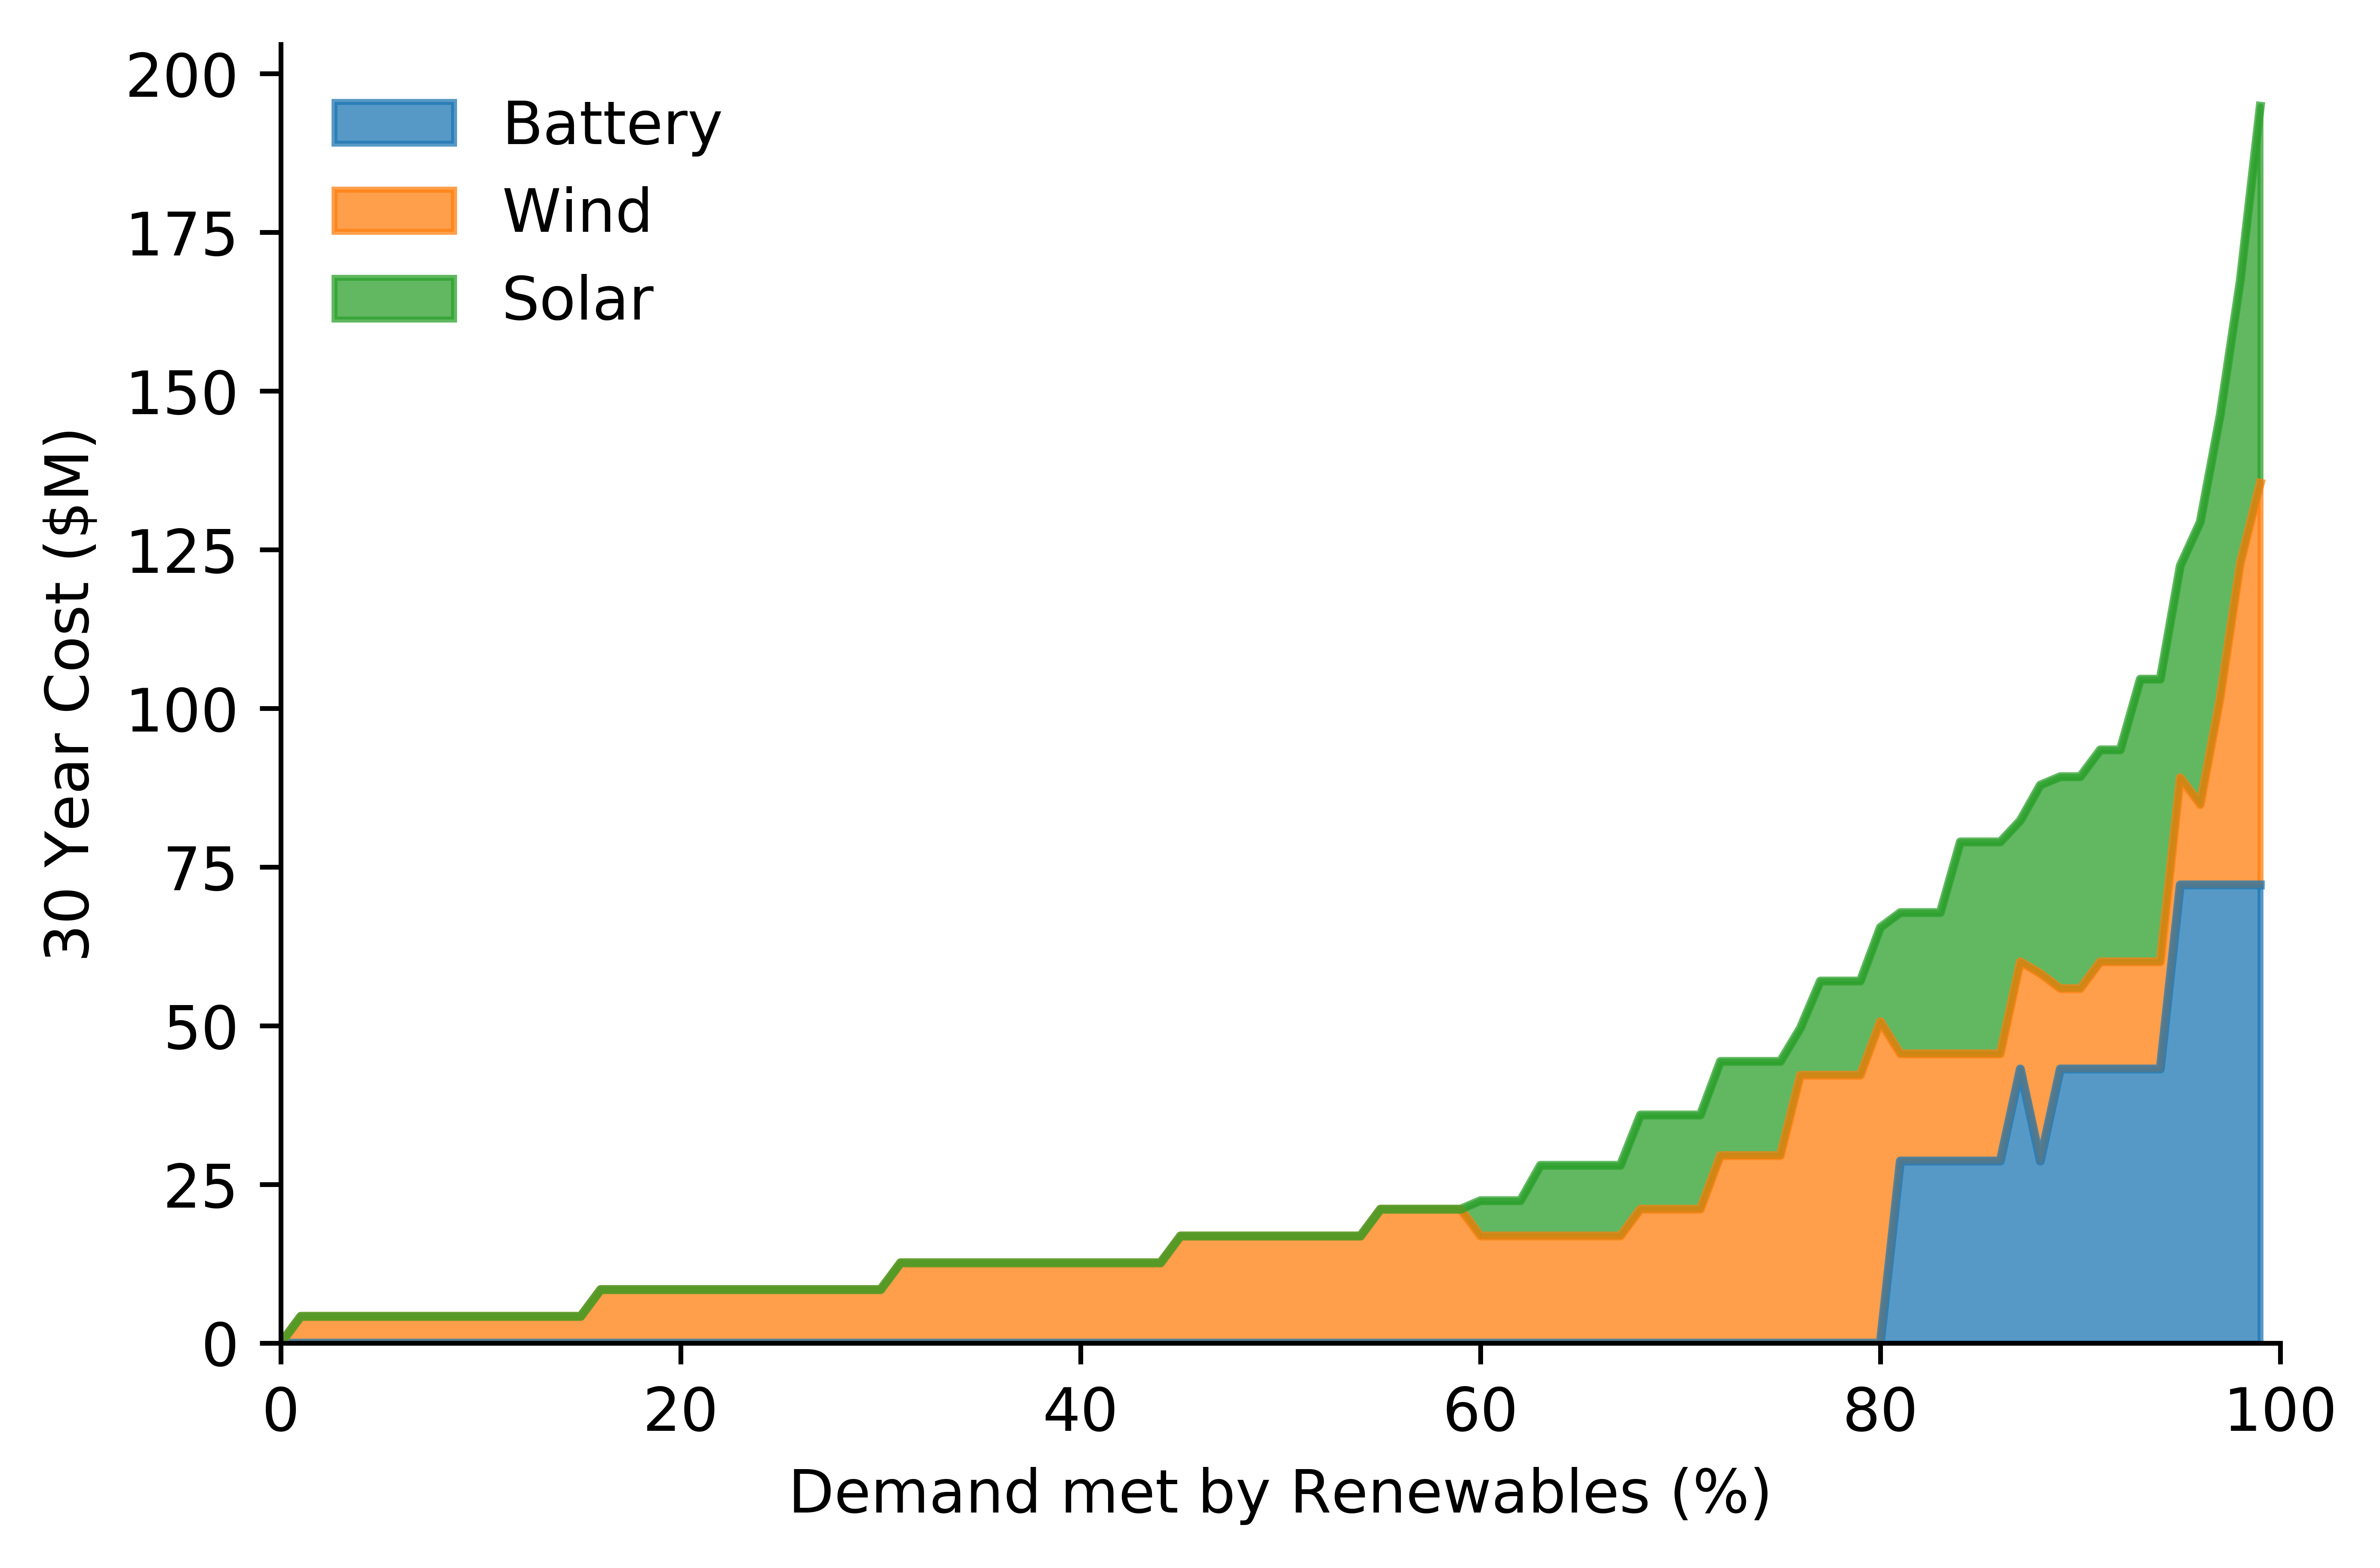

In [18]:
df_cheapest_models_plot = (df_cheapest_models
                           .rename(columns={'battery_cost':'Battery', 'wind_cost':'Wind', 'solar_cost':'Solar'}) 
                           .set_index('req_renew_pct')
                           [['Battery', 'Wind', 'Solar']]/1000000
                          )

fig = plt.figure(dpi=100)
ax = plt.subplot()    

df_cheapest_models_plot.plot.area(ax=ax, alpha=0.75)

## Look at matching colors with previous graphs - purple for storage, green for wind, yellow for solar

plt.xlim(0, 100)
plt.ylabel('30 Year Cost ($M)')
plt.xlabel('Demand met by Renewables (%)')

plt.legend(frameon=False)

ax.spines['right'].set_visible(False)     
ax.spines['top'].set_visible(False)

#plt.savefig('img/cost_curve.png')

In [16]:
## Extract amount of each generation type
s_models_str = pd.Series(df_cheapest_models.index, index=df_cheapest_models.index)

s_P = s_models_str.apply(lambda st: st[st.find("P")+1:st.find("_C")]).astype(int)
s_C = s_models_str.apply(lambda st: st[st.find("C")+1:st.find("_T")]).astype(int)
s_T = s_models_str.apply(lambda st: st[st.find("T")+1:st.find("_S")]).astype(int)
s_S = s_models_str.apply(lambda st: st[st.find("S")+1:]).astype(int)

df_cheapest_models['battery_power'] = s_P
df_cheapest_models['battery_capacity'] = s_C
df_cheapest_models['turbines'] = s_T
df_cheapest_models['panels'] = s_S

df_cheapest_models.head()

,req_renew_pct,total_cost,renew_pct,battery_cost,wind_cost,solar_cost,battery_power,battery_capacity,turbines,panels
model,,,,,,,,,,
P20_C0_T0_S0,0,0.0,0.000000,0.0,0.0,0.0,20,0,0,0
P20_C0_T1_S0,1,4220500.0,15.457574,0.0,4220500.0,0.0,20,0,1,0
P20_C0_T1_S0,2,4220500.0,15.457574,0.0,4220500.0,0.0,20,0,1,0
P20_C0_T1_S0,3,4220500.0,15.457574,0.0,4220500.0,0.0,20,0,1,0
P20_C0_T1_S0,4,4220500.0,15.457574,0.0,4220500.0,0.0,20,0,1,0


In [27]:
df_cheapest_models.tail(1)

,req_renew_pct,total_cost,renew_pct,battery_cost,wind_cost,solar_cost,battery_power,battery_capacity,turbines,panels
model,,,,,,,,,,
P10_C100_T15_S8000,99,194873500.0,99.055835,72190000.0,63307500.0,59376000.0,10,100,15,8000


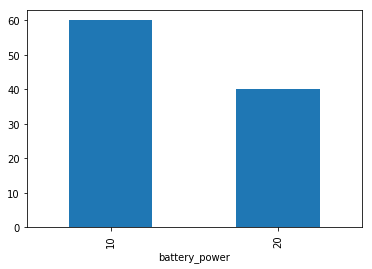

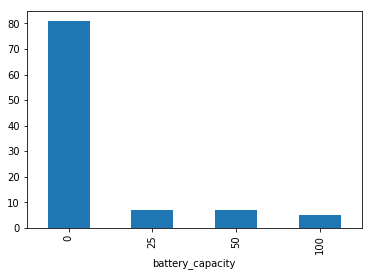

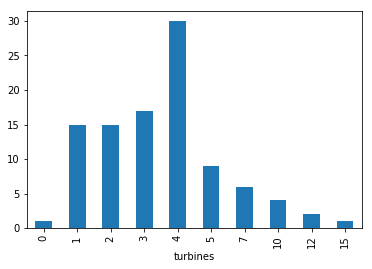

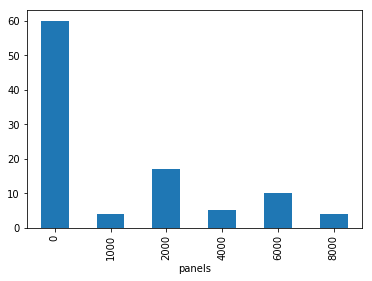

In [17]:
for col in ['battery_power', 'battery_capacity', 'turbines', 'panels']:
    plt.figure()
    df_cheapest_models.groupby(col).count()['req_renew_pct'].plot.bar(color='C0')